# A/B Testing Research about online word-of-mouth‘s inflence on product demand in the Chinese TV market

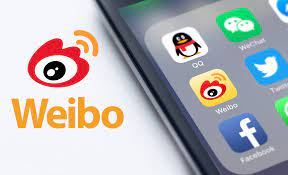

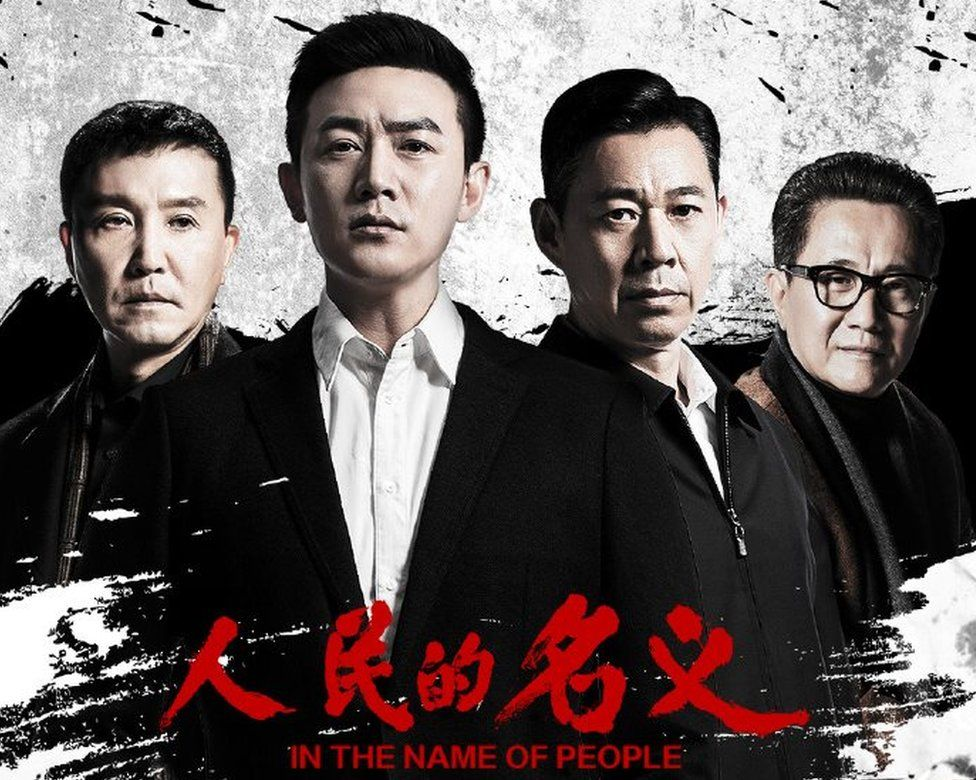

## The Goal:

#### In this project, we are trying to measure the impact of online word-of-mouth on product demand in the Chinese TV market. Specifically, we are interested in finding out whether consumers’ tweets about a TV show lead to higher viewership of the show. We obtained episode-level data of ratings (market-share in terms of viewership) for a large set of TV shows as well as information on the number of tweets on Sina Weibo (the Chinese version of Twitter) mentioning the name of the show on the day on which a specific episode aired. We also have data on ratings for a set of shows in Hong Kong, where Sina Weibo has almost no market penetration because Hong Kong residents mainly use Twitter (which is blocked in mainland China). The dataset we were using was weibo data.csv.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Part One: Simply regressing (log) ratings of each show onto the (log) number of tweets per episode and finding effects on # of tweets' influnce on ratings.

#### Load the data

In [2]:
weibo_data = pd.read_csv('weibo_data.csv')
weibo_data.head()

,location,show_id,episode_num,censor_dummy,log_rating,log_tweet,av_tweets,day_id,mainland_dummy
0,Mainland China,1,1,1,0.475764,0.000000,3.692308,33,1
1,Mainland China,1,2,0,0.468479,0.000000,3.692308,34,1
2,Mainland China,1,3,0,0.581327,1.386294,3.692308,35,1
3,Mainland China,1,4,0,0.547851,0.000000,3.692308,36,1
4,Mainland China,1,5,0,0.483728,1.386294,3.692308,37,1


In [3]:
lm  = smf.ols(formula = 'log_rating ~ log_tweet',data=weibo_data) 
result = lm.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             log_rating   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     987.9
Date:                Mon, 21 Feb 2022   Prob (F-statistic):          2.00e-204
Time:                        14:09:14   Log-Likelihood:                -87.734
No. Observations:                7899   AIC:                             179.5
Df Residuals:                    7897   BIC:                             193.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2664      0.003     81.566      0.0

### Finding:

#### The regression will not give me the casual effect because there should be some other variavles affecting the viewership. A simple linear model is enough to conclude the casual effect. For example, here might be seasonal effect on the view or the novelty effect as new show will have higher viewership. I believe it is biaed upwards since Hong Kong users don't use weibo

## Part Two: Geographic Diff-in-diff

### Background: During the time period of your data, the Chinese government blocked the entire Sina Weibo platform due to a political scandal for three days (a dummy for those three days called censor dummy is included in the data). Assume that the censorship constitutes an exogenous shock that affected the number of tweets during the three days it lasted. You want to exploit this shock in order to analyze whether ratings decreased during the censorship.

## Step One:
Running a regression of episode-level (log) ratings on show fixed effects and the censorship dummy using only data from mainland China.

In [4]:
from linearmodels import PanelOLS

In [5]:
data_censor = weibo_data[weibo_data['location']=='Mainland China']
data_censor = data_censor.set_index('show_id', append=True)
data_censor.index = data_censor.index.swaplevel(0,1)
data_censor.head()

location  episode_num  censor_dummy  log_rating  log_tweet  \
show_id                                                                       
1       0  Mainland China            1             1    0.475764   0.000000   
        1  Mainland China            2             0    0.468479   0.000000   
        2  Mainland China            3             0    0.581327   1.386294   
        3  Mainland China            4             0    0.547851   0.000000   
        4  Mainland China            5             0    0.483728   1.386294   

           av_tweets  day_id  mainland_dummy  
show_id                                       
1       0   3.692308      33               1  
        1   3.692308      34               1  
        2   3.692308      35               1  
        3   3.692308      36               1  
        4   3.692308      37               1

In [6]:
plm = PanelOLS(data_censor.log_rating, data_censor.censor_dummy, entity_effects=True)
print(plm.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:             log_rating   R-squared:                        0.0011
Estimator:                   PanelOLS   R-squared (Between):             -0.0050
No. Observations:                7899   R-squared (Within):               0.0011
Date:                Mon, Feb 21 2022   R-squared (Overall):             -0.0035
Time:                        14:09:15   Log-likelihood                    7841.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.6388
Entities:                         193   P-value                           0.0033
Avg Obs:                       40.927   Distribution:                  F(1,7705)
Min Obs:                       4.0000                                           
Max Obs:                       198.00   F-statistic (robust):             8.6388
                            

### The coefficient: **Coefficient of censor_dummy**: Holding showid fixed, difference in log_rating of three-day censor period and no censor period. 

## Finding:
### Result actually is as expected, If there exists the censorship in mainland China, I expect a decrease in log ratings of 0.0121704 units as opposed to the censorship does not exist because I controlled for show ID.

#### Note: show fixed effects

#### It is necessary to contol for show fixed effects. Since currently we only want to see that if censorship can effect the rating, show_id is additional variable which will effect our result. Therefore, we must control show fixed effects. If I run without show fixed effects, the coefficient will turn to given each show might have different impact on show viewership, how does having censorship’s associate with show viewership.

## Step Two:
Run the same regression as in step one, but use only data from **Hong Kong** (and not mainland China). Make sure to control for show fixed effects.

In [7]:
data_censor_hk = weibo_data[weibo_data['location']=='hongkong']
data_censor_hk = data_censor_hk.set_index('show_id', append=True)
data_censor_hk.index = data_censor_hk.index.swaplevel(0,1)
data_censor_hk.head()

location  episode_num  censor_dummy  log_rating  log_tweet  \
show_id                                                                    
194     7899  hongkong            1             0    0.087186        NaN   
        7900  hongkong            2             0    0.254720        NaN   
        7901  hongkong            3             0    0.156063        NaN   
        7902  hongkong            4             0    0.179484        NaN   
        7903  hongkong            5             0    0.184153        NaN   

              av_tweets  day_id  mainland_dummy  
show_id                                          
194     7899        0.0       1               0  
        7900        0.0       2               0  
        7901        0.0       3               0  
        7902        0.0       5               0  
        7903        0.0       6               0

In [8]:
plm_hk = PanelOLS(data_censor_hk.log_rating, data_censor_hk.censor_dummy, entity_effects=True)
print(plm_hk.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:             log_rating   R-squared:                        0.0003
Estimator:                   PanelOLS   R-squared (Between):              0.0011
No. Observations:                3528   R-squared (Within):               0.0003
Date:                Mon, Feb 21 2022   R-squared (Overall):              0.0006
Time:                        14:09:15   Log-likelihood                    1799.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.9093
Entities:                         132   P-value                           0.3404
Avg Obs:                       26.727   Distribution:                  F(1,3395)
Min Obs:                       2.0000                                           
Max Obs:                       139.00   F-statistic (robust):             0.9093
                            

### Coefficient of censor_dummy: Show_id fixed, difference in log_rating of three-day censor period and no censor period of Hongkong. 

## Finding:
### Result is what I expected Because weibo does not have much impact in Hongkong. Therefore, Hongkong viewership should not be affected by Weibo tweets. Result also shows insignificant, so censorship does not have a significant effect on hongkong show viewership.

## Step Three:
Using data from both Hong Kong and mainland China, implement a difference-in-differences regression with **mainland China** as the **treatment group** and **Hong Kong** as the **control group**. In other words, I want to show that the censorship event had a differential effect in mainland China relative to Hong Kong. Note: Make sure to control for show fixed effects.

In [9]:
weibo_data_index = weibo_data.set_index('show_id')
weibo_data_index

,location,episode_num,censor_dummy,log_rating,log_tweet,av_tweets,day_id,mainland_dummy
show_id,,,,,,,,
1,Mainland China,1,1,0.475764,0.000000,3.692308,33,1
1,Mainland China,2,0,0.468479,0.000000,3.692308,34,1
1,Mainland China,3,0,0.581327,1.386294,3.692308,35,1
1,Mainland China,4,0,0.547851,0.000000,3.692308,36,1
1,Mainland China,5,0,0.483728,1.386294,3.692308,37,1
...,...,...,...,...,...,...,...,...
342,hongkong,33,0,0.476110,NaN,0.000000,51,0
342,hongkong,34,0,0.432756,NaN,0.000000,54,0
342,hongkong,35,0,0.303211,NaN,0.000000,55,0


In [10]:
model = smf.ols(formula='log_rating ~ C(show_id)+censor_dummy + censor_dummy:mainland_dummy', data=weibo_data)

In [11]:
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             log_rating   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     910.8
Date:                Mon, 21 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:09:15   Log-Likelihood:                 9018.9
No. Observations:               11427   AIC:                        -1.738e+04
Df Residuals:                   11100   BIC:                        -1.498e+04
Df Model:                         326                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

## Finding:
### censor_dummy: as shown in the previous question, if there exists the censorship in Hong Kong, we should expect the log ratings will increase 0.0106 united compared to if the censorship does not exist when we control for show ID. interaction term: the differential change for the log ratings between mainland China and Hong Kong given there is a censorship in both locations is -0.0227 when we control for show ID. (This can be verified by subtracting the coefficients values from previous questions )


## Part Three: Across-show Diff-in-diff (use only observations from shows in mainland China)

### About the Dataset:
The variable av tweets denotes the average number of tweets associated with an episode of each show (outside of the censored time period). Therefore, this variable is show specific, but it does not vary over time. We can use this variable to capture the general level of social media interest in each show. Generate a set of three dummy variables based on the av tweets variable: The first dummy is equal to one for shows with fewer than 5 tweets per episode, the second dummy is equal to one for shows with at least 5 but less than 100 tweets per episode, and the third dummy should be equal to one for shows with at least 100 tweets per episode.

## Step One:
Run three separate regressions for shows with less than 5 tweets per episode, shows with 5 to 100 tweets per episode and shows with at least 100 tweets. 

In [12]:
weibo_data['first_dummy']= weibo_data['av_tweets']<5
weibo_data['second_dummy']= weibo_data['av_tweets'].between(5,100,inclusive =False)
weibo_data['third_dummy']= weibo_data['av_tweets']>=100
weibo_data

,location,show_id,episode_num,censor_dummy,log_rating,log_tweet,av_tweets,day_id,mainland_dummy,first_dummy,second_dummy,third_dummy
0,Mainland China,1,1,1,0.475764,0.000000,3.692308,33,1,True,False,False
1,Mainland China,1,2,0,0.468479,0.000000,3.692308,34,1,True,False,False
2,Mainland China,1,3,0,0.581327,1.386294,3.692308,35,1,True,False,False
3,Mainland China,1,4,0,0.547851,0.000000,3.692308,36,1,True,False,False
4,Mainland China,1,5,0,0.483728,1.386294,3.692308,37,1,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
11422,hongkong,342,33,0,0.476110,NaN,0.000000,51,0,True,False,False
11423,hongkong,342,34,0,0.432756,NaN,0.000000,54,0,True,False,False
11424,hongkong,342,35,0,0.303211,NaN,0.000000,55,0,True,False,False
11425,hongkong,342,36,0,0.436511,NaN,0.000000,56,0,True,False,False


In [13]:
data_censor131 = weibo_data[(weibo_data['location']=='Mainland China') & (weibo_data['first_dummy']==True)]
data_censor131 = data_censor131.set_index('show_id', append=True)
data_censor131.index = data_censor131.index.swaplevel(0,1)
data_censor131.head()

location  episode_num  censor_dummy  log_rating  log_tweet  \
show_id                                                                       
1       0  Mainland China            1             1    0.475764   0.000000   
        1  Mainland China            2             0    0.468479   0.000000   
        2  Mainland China            3             0    0.581327   1.386294   
        3  Mainland China            4             0    0.547851   0.000000   
        4  Mainland China            5             0    0.483728   1.386294   

           av_tweets  day_id  mainland_dummy  first_dummy  second_dummy  \
show_id                                                                   
1       0   3.692308      33               1         True         False   
        1   3.692308      34               1         True         False   
        2   3.692308      35               1         True         False   
        3   3.692308      36               1         True         False   
        4   3.692308      37               1         True         False   

           third_dummy  
show_id                 
1       0        False  
        1        False  
        2        False  
        3        False  
        4        False

In [14]:
plm131 = PanelOLS(data_censor131.log_rating, data_censor131.censor_dummy, entity_effects=True)
print(plm131.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:             log_rating   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):             -0.0043
No. Observations:                3405   R-squared (Within):               0.0005
Date:                Mon, Feb 21 2022   R-squared (Overall):             -0.0027
Time:                        14:09:16   Log-likelihood                    4134.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      1.7572
Entities:                          88   P-value                           0.1851
Avg Obs:                       38.693   Distribution:                  F(1,3316)
Min Obs:                       4.0000                                           
Max Obs:                       145.00   F-statistic (robust):             1.7572
                            

In [15]:
data_censor132 = weibo_data[(weibo_data['location']=='Mainland China') & (weibo_data['second_dummy']==True)]
data_censor132 = data_censor132.set_index('show_id', append=True)
data_censor132.index = data_censor132.index.swaplevel(0,1)
data_censor132.head()

location  episode_num  censor_dummy  log_rating  log_tweet  \
show_id                                                                         
3       106  Mainland China            1             0    0.824967   3.737670   
        107  Mainland China            2             0    0.784216   1.791759   
        108  Mainland China            3             0    0.812299   3.401197   
        109  Mainland China            4             0    0.870158   3.258097   
        110  Mainland China            5             0    0.876738   3.496508   

             av_tweets  day_id  mainland_dummy  first_dummy  second_dummy  \
show_id                                                                     
3       106  39.515152      27               1        False          True   
        107  39.515152      28               1        False          True   
        108  39.515152      28               1        False          True   
        109  39.515152      29               1        False          True   
        110  39.515152      29               1        False          True   

             third_dummy  
show_id                   
3       106        False  
        107        False  
        108        False  
        109        False  
        110        False

In [16]:
plm132 = PanelOLS(data_censor132.log_rating, data_censor132.censor_dummy, entity_effects=True)
print(plm132.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:             log_rating   R-squared:                        0.0001
Estimator:                   PanelOLS   R-squared (Between):             -0.0014
No. Observations:                2926   R-squared (Within):               0.0001
Date:                Mon, Feb 21 2022   R-squared (Overall):             -0.0011
Time:                        14:09:16   Log-likelihood                    2895.3
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.3675
Entities:                          62   P-value                           0.5444
Avg Obs:                       47.194   Distribution:                  F(1,2863)
Min Obs:                       4.0000                                           
Max Obs:                       198.00   F-statistic (robust):             0.3675
                            

In [17]:
data_censor133 = weibo_data[(weibo_data['location']=='Mainland China') & (weibo_data['third_dummy']==True)]
data_censor133 = data_censor133.set_index('show_id', append=True)
data_censor133.index = data_censor133.index.swaplevel(0,1)
data_censor133.head()

location  episode_num  censor_dummy  log_rating  log_tweet  \
show_id                                                                         
4       145  Mainland China            1             0    0.908442   4.644391   
        146  Mainland China            2             0    0.729686   4.043051   
        147  Mainland China            3             0    0.784416   2.639057   
        148  Mainland China            4             0    0.719669   2.639057   
        149  Mainland China            5             0    0.790701   6.766191   

             av_tweets  day_id  mainland_dummy  first_dummy  second_dummy  \
show_id                                                                     
4       145  131.21051       1               1        False         False   
        146  131.21051       2               1        False         False   
        147  131.21051       3               1        False         False   
        148  131.21051       4               1        False         False   
        149  131.21051       5               1        False         False   

             third_dummy  
show_id                   
4       145         True  
        146         True  
        147         True  
        148         True  
        149         True

In [18]:
plm133 = PanelOLS(data_censor133.log_rating, data_censor133.censor_dummy, entity_effects=True)
print(plm133.fit())

                          PanelOLS Estimation Summary                           
Dep. Variable:             log_rating   R-squared:                        0.0057
Estimator:                   PanelOLS   R-squared (Between):             -0.0110
No. Observations:                1549   R-squared (Within):               0.0057
Date:                Mon, Feb 21 2022   R-squared (Overall):             -0.0083
Time:                        14:09:16   Log-likelihood                    1090.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      8.5840
Entities:                          42   P-value                           0.0034
Avg Obs:                       36.881   Distribution:                  F(1,1506)
Min Obs:                       9.0000                                           
Max Obs:                       168.00   F-statistic (robust):             8.5840
                            

## Findings about impact of the censorship event across the three regressions:  
### only when above 100, it shows statistically significant. Mostly Censorship will affect most when tweets are over 100 for an episode, we can see that the coefficient of censor_dummy is increasing with the average number of tweets increasing. 

## Step Two:
Run a difference-in-difference regression that allows for the censorship event to have a different effect for three sets of shows with the three different activity levels defined above.

In [19]:
data_censor13b = weibo_data[weibo_data['location']=='Mainland China']

In [20]:
model13b = smf.ols(formula='log_rating ~ C(show_id)+ censor_dummy + censor_dummy:second_dummy + censor_dummy:third_dummy', data=data_censor13b)
results = model13b.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_rating   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     291.7
Date:                Mon, 21 Feb 2022   Prob (F-statistic):               0.00
Time:                        14:09:16   Log-Likelihood:                 7845.2
No. Observations:                7899   AIC:                        -1.530e+04
Df Residuals:                    7703   BIC:                        -1.393e+04
Df Model:                         195                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                             0.5573      0.024     22.973      0.000       0.510       0.605
C(show_id)[T.2]                      -0.0064      0.026     -0.245      0.807      -0.057       0.045
C(show_id)[T.3]                       0.3285      0.028     11.606      0.000       0.273       0.384
C(show_id)[T.4]                       0.1976      0.027      7.333      0.000       0.145       0.250
C(show_id)[T.5]                       0.6119      0.027     22.744      0.000       0.559       0.665
C(show_id)[T.6]                       0.0081      0.028      0.287      0.774      -0.047       0.063
C(show_id)[T.7]                      -0.1043      0.027     -3.875      0.000      -0.157      -0.052
C(show_id)[T.8]                       0.9448      0.027     35.119      0.000       0.892       0.998
C(show_id)[T.9]                      -0.1461      0.029     -5.088      0.000      -0.202      -0.090
C(show_id)[T.10]                      0.0970      0.042      2.308      0.021       0.015       0.179
C(show_id)[T.11]                     -0.4185      0.036    -11.716      0.000      -0.489      -0.348
C(show_id)[T.12]                     -0.4623      0.047     -9.751      0.000      -0.555      -0.369
C(show_id)[T.13]                     -0.3999      0.032    -12.351      0.000      -0.463      -0.336
C(show_id)[T.14]                     -0.3806      0.027    -14.127      0.000      -0.433      -0.328
C(show_id)[T.15]                     -0.4000      0.026    -15.137      0.000      -0.452      -0.348
C(show_id)[T.16]                     -0.3591      0.028    -12.930      0.000      -0.414      -0.305
C(show_id)[T.17]                     -0.3261      0.040     -8.098      0.000      -0.405      -0.247
C(show_id)[T.18]                     -0.3146      0.028    -11.295      0.000      -0.369      -0.260
C(show_id)[T.19]                     -0.4102      0.039    -10.569      0.000      -0.486      -0.334
C(show_id)[T.20]                     -0.0682      0.039     -1.757      0.079      -0.144       0.008
C(show_id)[T.21]                      0.0575      0.034      1.675      0.094      -0.010       0.125
C(show_id)[T.22]                     -0.1946      0.029     -6.691      0.000      -0.252      -0.138
C(show_id)[T.23]                     -0.2697      0.044     -6.089      0.000      -0.356      -0.183
C(show_id)[T.24]                     -0.1165      0.042     -2.773      0.006      -0.199      -0.034
C(show_id)[T.25]                      0.1265      0.030      4.205      0.000       0.068       0.186
C(show_id)[T.26]                     -0.2749      0.026    -10.453      0.000      -0.326      -0.223
C(show_id)[T.27]                     -0.3945      0.028    -14.127      0.000      -0.449      -0.340
C(show_id)[T.28]       

## Intercepts:
#### Intercept: Expected (log) ratings for the default show 1

#### Fixed effects: Differential rating change for the show vs default

#### censor_dummy: Differential rating change for a show with censor vs without

#### censor_dummy:second_dummy[T.True]: Differential rating change for a show with 5-100 tweets with censor compared to a show with <5 tweets with censor

#### censor_dummy:third_dummy[T.True]: Differential rating chang for show with >100 tweets with censor compared to a show with <5 tweets with censor

## My finding for Across-show Diff-in-diff: 
#### For geographic one, it told me if mainland and hongkong has censorship or not. The regressions with different activity levels provide details on how censorship affects shows with different levels of engagement. The findings across shows with different activity levels are more informative because it provides detailed about the impact of censorship on ratings.